In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Dropout 

Another option for neural network regularization is adding a ​dropout layer​. This type of layer disables some neurons, while the others pass through unchanged. The idea here, similarly to regularization, is to prevent a neural network from becoming too dependent on any neuron or for any neuron to be relied upon entirely in a specific instance (which can be common if a model overfits the training data). Another problem dropout can help with is ​co-adoption​,​ ​which happens when neurons depend on the output values of other neurons and do not learn the underlying function on their own. Dropout can also help with ​noise​ and other perturbations in the training data as more neurons working together mean that the model can learn more complex functions. The Dropout function works by randomly disabling neurons at a given rate during every forward pass, forcing the network to learn how to make accurate predictions with only a random part of neurons remaining. Dropout forces the model to use more neurons for the same purpose, resulting in a higher chance of learning the underlying function that describes the data. For example, if we disable one half of the neurons during the current step, and the other half during the next step, we are forcing more neurons to learn the data, as only a part of them “sees” the data and gets updates in a given pass. These alternating halves of neurons are an example, and in reality, we’ll use a hyperparameter to inform the dropout layer of the number of neurons to disable randomly. Also, since active neurons are changing, dropout helps prevent overfitting, as the model can’t use specific neurons to memorize certain samples. It’s also worth mentioning that the dropout layer does not truly disable neurons, but instead zeroes their outputs. In other words, dropout does not decrease the number of neurons used, nor does it make the training process twice as fast when half the neurons are disabled.

## Forward Pass 

In the code, we will “turn off” neurons with a filter that is an array with the same shape as the layer output but filled with numbers drawn from a Bernoulli distribution. A ​Bernoulli distribution​ is a binary (or discrete) probability distribution where we can get a value of ​1​ with a probability of ​p​ and value of ​0​ with a probability of ​q​. Let’s take some random value from this distribution, ​ri​ ​, then:

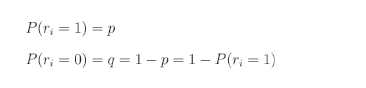

What this means is that the probability of this value being ​1​ is ​p.​ The probability of it being ​0​ is ​q = 1 - p,​ therefore:

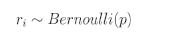
This means that the given ​ri​ ​ is an equivalent of a value from the Bernoulli distribution with a probability ​p​ for this value to be ​1​. If ​ri​ ​ is a single value from this distribution, a draw from this distribution, reshaped to match the shape of the layer outputs, can be used as a mask to these outputs. We are returned an array filled with values of ​1​ with a probability of ​p​ and otherwise values of ​0.​ We then apply this filter to the output of a layer we want to add dropout to.

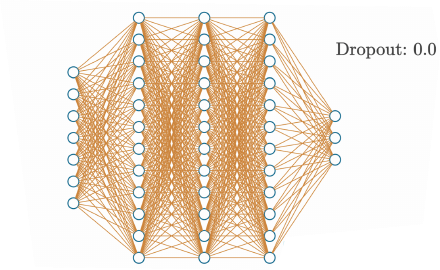
Figure 1:​ Example model with no dropout applied.

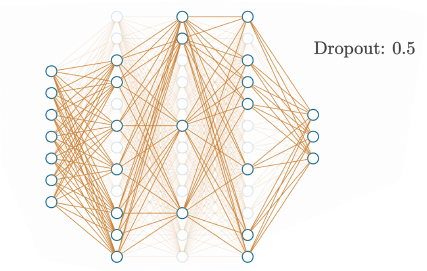
Figure 2:​Example model with 0.5 dropout.

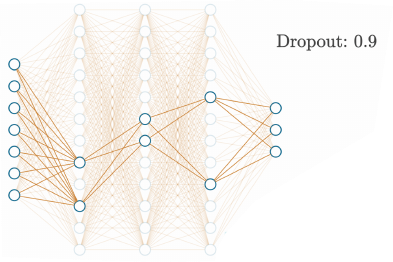

Figure 3:​ Example model with 0.9 dropout.

With the code, we have one hyperparameter for a dropout layer. This is a value for the percentage of neurons to disable in that layer. For example, if you chose 0.10 for the dropout parameter, 10% of the neurons will be disabled at random during each forward pass. Before we use NumPy, we’ll demonstrate this with an example in pure Python:
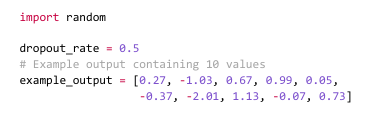

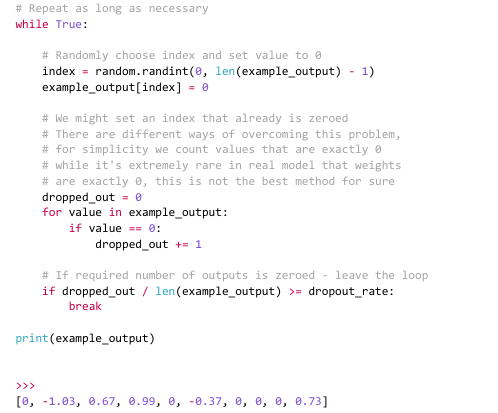


The code is relatively rudimentary, but the idea is to keep zeroing neuron outputs (setting them to 0) randomly until we’ve disabled whatever target % of neurons we require. If we consider a Bernoulli distribution as a special case of a Binomial distribution with ​n=1​ and look at a list of available methods in NumPy, it turns out that there’s a much cleaner way to do this using numpy.random.binomial.​ A binomial distribution differs from Bernoulli distribution in one way, as it adds a parameter, ​n,​ which is the number of concurrent experiments (instead of just one) and returns the number of successes from these ​n​ experiments. np.random.binomial() works by taking the already discussed parameters ​n (number of experiments) and ​p (probability of the true value of the experiment) as well as an additional parameter ​size:​ ​np.random.binomial(n, p, size)​.
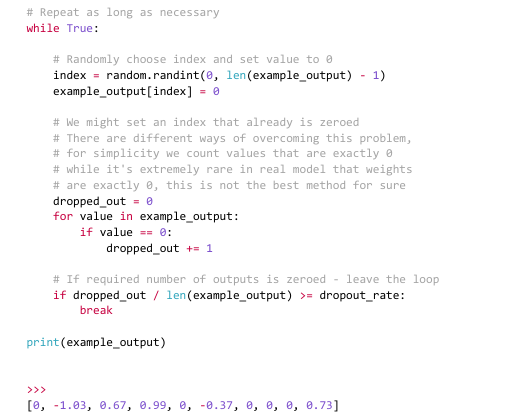

The code is relatively rudimentary, but the idea is to keep zeroing neuron outputs (setting them to 0) randomly until we’ve disabled whatever target % of neurons we require. If we consider a Bernoulli distribution as a special case of a Binomial distribution with ​n=1​ and look at a list of available methods in NumPy, it turns out that there’s a much cleaner way to do this using numpy.random.binomial.​ A binomial distribution differs from Bernoulli distribution in one way, as it adds a parameter, ​n,​ which is the number of concurrent experiments (instead of just one) and returns the number of successes from these ​n​ experiments. np.random.binomial() works by taking the already discussed parameters ​n (number of experiments) and ​p (probability of the true value of the experiment) as well as an additional parameter ​size:​ ​np.random.binomial(n, p, size)​.

The function itself can be thought of like a coin toss, where the result will be 0 or 1. The ​n​ is how many tosses of the coin do you want to do. The ​p​ is the probability for the toss result to be a 1. The overall result is a sum of all toss results. The ​size​ is how many of these “tests” to run, and the return is a list of overall results. For example:

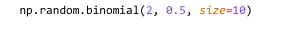


This will produce an array that is of size 10, where each element will be the sum of 2 coin tosses, where the probability of 1 will be 0.5, or 50%. The resulting array:

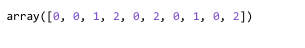
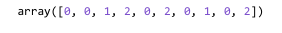

We can use this to create our dropout layer. Our goal here is to create a filter where the intended dropout % is represented as 0, with everything else as 1. For example, let’s say we have a dropout layer that we’ll add after a layer that consists of 5 neurons, and we wish to have a 20% dropout. An example of a dropout layer might look like:

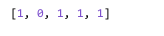
As you can see, ⅕ of that list is a 0. This is an example of the filter we’re going to apply to the output of the dense layer. If we multiplied a neural network’s layer output by this, we’d be effectively disabling the neuron at the same index as the 0. We can mimic that with ​np.random.binomial()​ by doing:

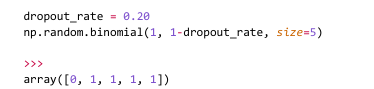

This is based on probabilities, so there will be times when it does not look like the above array. There could be times no neurons zero out, or all neurons zero out. On average, these random draws will tend toward the probability we desire. Also, this was an example using a very small layer (5 neurons). On a realistically sized layer, you should find the probability more consistently matches your intended value.

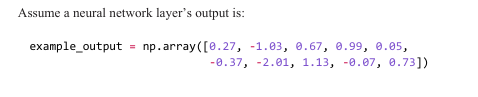

Next, let’s assume our target dropout rate is 0.3, or 30%. We apply a dropout layer:

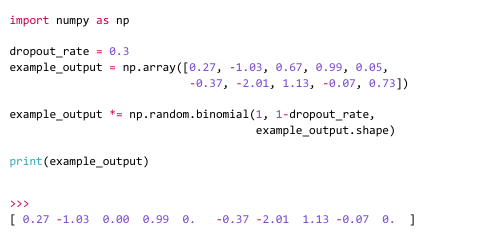

Note that our dropout rate is the ratio of neurons we intend to ​disable​ ​(q)​. Sometimes, the implementation of dropout will include a rate parameter that instead means the fraction of neurons you intend to ​keep​ ​(p)​. At the time of writing this, the dropout parameter in deep learning frameworks, TensorFlow and Keras, represents the neurons you intend to disable. On the other hand, the dropout parameter in PyTorch and the original paper on dropout (​http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf​)​ signal the ratio of neurons you intend to keep.
The way it’s implemented is not important. What ​is​ important is that you know which method you’re using! While dropout helps a neural network generalize and is helpful for training, it’s not something we want to utilize when predicting. It’s not as simple as only omitting it because the magnitude of inputs to the next neurons can be dramatically different. If you have a dropout of 50%, for example, this would suggest that, on average, your inputs to the next layer neurons will be 50% smaller when summed, assuming they are fully-connected. What that means is that we used dropout during training, and, in this example, a random 50% of neurons output a value of 0 at each of the steps. Neurons in the next layer multiply inputs by weights, sum them, and receive values of 0 for half of their inputs. If we don’t use dropout during prediction, all neurons will output their values, and this state won’t match the state seen during training, since the sums will be statistically about twice as big. To handle this, during prediction, we might multiply all of the outputs by the dropout fraction, but that’d add another step for the forward pass, and there is a better way to achieve this. Instead, we want to scale the data back up after a dropout, during the training phase, to mimic the mean of the sum when all of the neurons output their values. Example_output​ becomes:
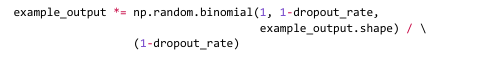

1 Notice that we added the division of the dropout’s result by the dropout rate. Since this rate is a fraction, it makes the resulting values larger, accounting for the value lost because a fraction of the neuron outputs being zeroed out. This way, we don’t have to worry about the prediction and can simply omit the dropout during prediction. In any specific example, you will find that scaling doesn’t equal the same sum as before because we’re randomly dropping neurons. That said, after enough samples, the scaling will average out overall. To prove this:

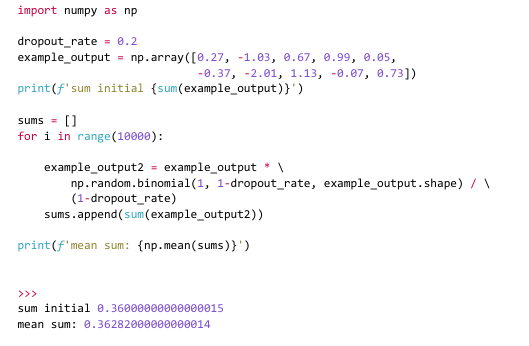

It’s not exact yet, but you should get the idea.





## Backward Pass 

The last missing piece to implement dropout as a layer is a backward pass method. As before, we need to calculate the partial derivative of the dropout operation: When the value of element ​r​i​ equals ​1,​ its function and derivative becomes the neuron’s output, ​z,​ compensated for the loss value by ​1-q​, where ​q​ is the dropout rate, as we just described:
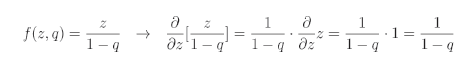

That’s because the derivative with respect to ​z​ of ​z​ is 1, and we treat the rest as a constant. When​r​i=0 ​ :​
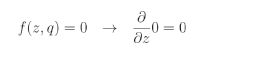

And that’s because we are zeroing this element of the dropout filter, and the derivative of any constant value (including ​0​) is ​0​. Let’s combine both cases and denote ​Dropout​ as ​Dr​:

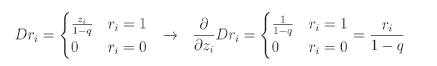


i​ denotes the index of the given input (and the layer output). When we write a derivative of the dropout function this way, we can simplify it to a value from the Bernoulli distribution divided by 1-q,​ which is identical to our scaled mask, the function the dropout applies during the forward pass, as it’s also either ​1​ divided by ​1-q​, or ​0​. Thus, we can save this mask during the forward pass and use it with the chain rule as the gradient of this function.


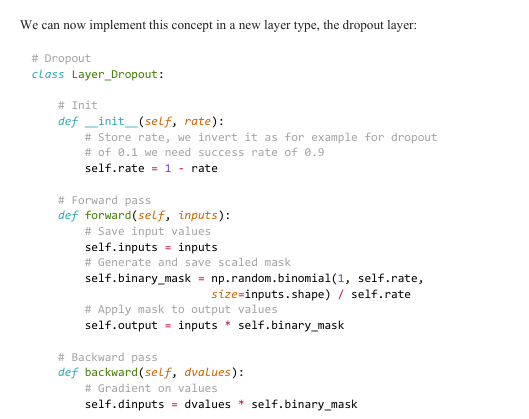
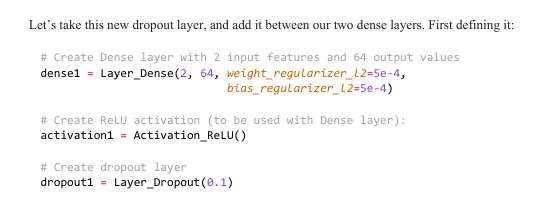
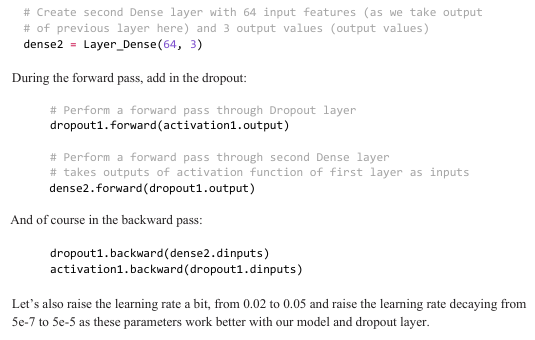




In [ ]:
import numpy as np
# Function to create spiral data (similar to nnfs)
def spiral_data(samples, classes):
    X = np.zeros((samples * classes, 2))  # Input features
    y = np.zeros(samples * classes, dtype='uint8')  # Class labels
    for class_number in range(classes):
        ix = range(samples * class_number, samples * (class_number + 1))
        r = np.linspace(0.0, 1, samples)  # Radius
        t = np.linspace(class_number * 4, (class_number + 1) * 4, samples) + np.random.randn(samples) * 0.2  # Theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_number
    return X, y


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0



# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1
# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights * \
                                          layer.weights)


        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases * \
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Create dataset
X, y = spiral_data(samples=1000, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4,
                            bias_regularizer_l2=5e-4)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create dropout layer
dropout1 = Layer_Dropout(0.1)

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-5)

# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)


    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through Dropout layer
    dropout1.forward(activation1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(dropout1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense2.output, y)

    # Calculate regularization penalty
    regularization_loss = \
        loss_activation.loss.regularization_loss(dense1) + \
        loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss
    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    
# Validate the model

# Create test dataset
X_test, y_test = spiral_data(samples=100, classes=3)

# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)

# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y_test)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')





epoch: 0, acc: 0.257, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.958, loss: 0.189 (data_loss: 0.135, reg_loss: 0.054), lr: 0.04975371909050202
epoch: 200, acc: 0.976, loss: 0.124 (data_loss: 0.086, reg_loss: 0.038), lr: 0.049507401356502806
epoch: 300, acc: 0.976, loss: 0.115 (data_loss: 0.084, reg_loss: 0.031), lr: 0.0492635105177595
epoch: 400, acc: 0.975, loss: 0.104 (data_loss: 0.076, reg_loss: 0.028), lr: 0.04902201088288642
epoch: 500, acc: 0.980, loss: 0.105 (data_loss: 0.078, reg_loss: 0.027), lr: 0.048782867456949125
epoch: 600, acc: 0.983, loss: 0.099 (data_loss: 0.074, reg_loss: 0.025), lr: 0.04854604592455945
epoch: 700, acc: 0.980, loss: 0.094 (data_loss: 0.070, reg_loss: 0.024), lr: 0.048311512633460556
epoch: 800, acc: 0.980, loss: 0.089 (data_loss: 0.066, reg_loss: 0.023), lr: 0.04807923457858551
epoch: 900, acc: 0.982, loss: 0.088 (data_loss: 0.065, reg_loss: 0.022), lr: 0.04784917938657352
epoch: 1000, acc: 0.981, loss: 0.088 (data_lo

epoch: 8400, acc: 0.992, loss: 0.037 (data_loss: 0.024, reg_loss: 0.013), lr: 0.03521250748265784
epoch: 8500, acc: 0.992, loss: 0.046 (data_loss: 0.032, reg_loss: 0.014), lr: 0.035088950489490865
epoch: 8600, acc: 0.992, loss: 0.044 (data_loss: 0.030, reg_loss: 0.013), lr: 0.0349662575614532
epoch: 8700, acc: 0.992, loss: 0.038 (data_loss: 0.024, reg_loss: 0.014), lr: 0.034844419666190465
epoch: 8800, acc: 0.993, loss: 0.048 (data_loss: 0.035, reg_loss: 0.013), lr: 0.034723427896801974
epoch: 8900, acc: 0.988, loss: 0.052 (data_loss: 0.037, reg_loss: 0.015), lr: 0.03460327346967023
epoch: 9000, acc: 0.990, loss: 0.039 (data_loss: 0.026, reg_loss: 0.013), lr: 0.034483947722335255
epoch: 9100, acc: 0.993, loss: 0.042 (data_loss: 0.028, reg_loss: 0.014), lr: 0.034365442111412764


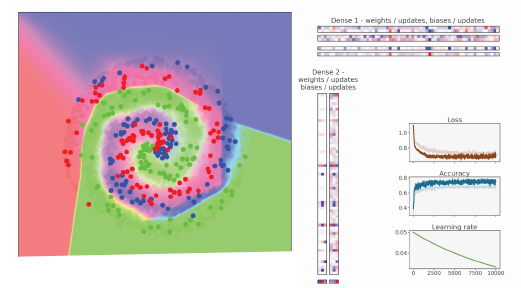
Figure 4:​ Model trained with dropout.
While our accuracy and loss have suffered considerably, we’ve found a scenario where our validation set performs ​better​ than our in-sample set (because we do not apply dropout when testing so you don’t disable some of the connections). Further tweaking would likely fix the accuracy issue; for example, due to our regularization tactics, we can change our layer sizes to 512:
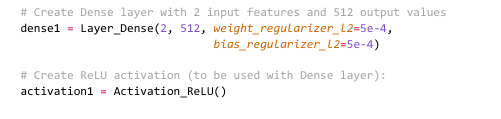
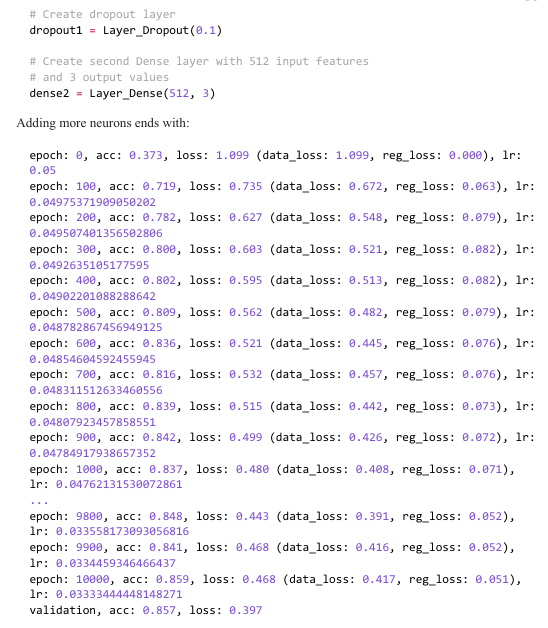

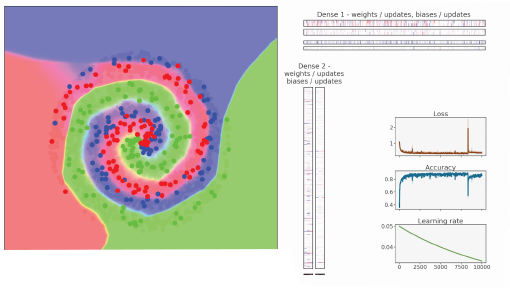
Figure 5:​ Model trained with dropout and bigger hidden layer.
Pretty good result, but worse compared to the “no dropout” model. Interestingly, validation accuracy is close to the training accuracy with dropout — usually validation accuracy will be higher, so we might suspect these as signs of overfitting here (validation loss is lower than expected).